# ANN assisted TPS on capped alanine dipeptide 1.5
In this notebook you will learn:
- how to continue an ANN assisted TPS simulation using a new ops storage file to avoid ever increasing file sizes

This notebook assumes some familiarity with `openpathsampling` and `aimmd`, please do the Toy notebooks first.
It also depends on files generated in `1_keras_setup_and_TPS.ipynb`, so if you haven't please do this notebook first.

In [1]:
%matplotlib inline

In [2]:
# to be able to run multiple notebooks in paralell:
# tell tf to not grab the whole GPU memory available
import tensorflow as tf
if tf.version.VERSION.startswith('2.'):
    # tell tf to use only the GPU mem it needs
    gpus = tf.config.experimental.list_physical_devices('GPU')
    print('available GPUs: ', gpus)
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    from tensorflow.keras import backend as K

else:
    conf = tf.compat.v1.ConfigProto()
    conf.gpu_options.allow_growth = True
    conf.gpu_options.per_process_gpu_memory_fraction = 0.25
    #tf.enable_eager_execution(config=conf)\n",
    sess = tf.compat.v1.Session(config=conf)
    from tensorflow.keras import backend as K
    K.set_session(sess)

available GPUs:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
import os
import aimmd
import numpy as np
import mdtraj as md
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 9, 6  # make the figures a bit bigger
import openpathsampling as paths
import openpathsampling.engines.openmm as peng_omm
import simtk.openmm as mm
import simtk.unit as unit
from simtk.openmm import app
from openmmtools.integrators import VVVRIntegrator

In [4]:
# setup logging
# executing this file sets the variable LOGCONFIG, which is a dictionary of logging presets 
%run ../resources/logconf.py

In [5]:
LOGCONFIG['handlers']['stdf']['filename'] = 'keras_simulation.log1'
LOGCONFIG['handlers']['initf']['filename'] = 'keras_init.log1'

In [6]:
cur_dir = os.path.abspath(os.getcwd())  # needed for relative paths to initial TP
# change to the working directory of choice
wdir = '/home/tb/hejung/DATA/aimmd_scratch/SimData_keras_ala/'
#wdir = None
if wdir is not None:
    os.chdir(wdir)

# setup logging in that directory
import logging.config
logging.config.dictConfig(LOGCONFIG)

### load the old/previous storage file

In [7]:
old_storage = paths.Storage(os.path.join(wdir, 'ala_LB_keras_ResNet.nc'), 'r')

### create the new storage

In [8]:
template = old_storage.snapshots[0]
storage = paths.Storage(os.path.join(wdir, 'ala_LB_TPS_keras1.nc'), 'w', template=template)
# explicitly save one snapshot to the storage...somehow passing template does not work?!
storage.save(template)
# note that this is not strictly necessary sicne we copy over some snapshots below for the density colelction to work

(store.snapshots[BaseSnapshot] : 2 object(s),
 2,
 291078701144272579615956780138759192592)

In [9]:
# TODO/FIXME: this is a bit ugly!
# for the density collection to work
# we need to copy over all MCSteps from the last to and including the last accept
# first find out what the last accept is
i = -1
accepted = False
while not accepted:
    accepted = old_storage.steps[i].change.accepted
    i -= 1
print(i)
# now copy over all steps including the last accept
while i < 0:
    storage.save(old_storage.steps[i])
    i += 1

(WARNING)aimmd.ops.selector: Restoring RCModelSelector without model.Please take care of resetting the model yourself.


-3


### open (old) aimmd_storage
Note that as for the ops sorage you could just keep using the old one.

In [10]:
old_aimmd_storage = aimmd.Storage("aimmd_storage.h5", "r")

In [11]:
aimmd_storage = aimmd.Storage("aimmd_storage1.h5", "w")

### load the needed objects from the old storage(s)

In [12]:
# there should only be one Pathsampling object, but better check than be sorry :)
old_storage.pathsimulators[:]

In [13]:
# load the model
model = old_aimmd_storage.rcmodels["most_recent"]

(WARNING)aimmd.base.rcmodel: aimmd storage passed as density collector cache file is open in read-only mode. No appending will be possible.


In [14]:
# transfer the model to the new aimmd_storage
aimmd_storage.rcmodels["restart_of_sim"] = model
# loading it now makes sure we can append to the density collector (as it now points to the new storage open in write/append mode)
model = aimmd_storage.rcmodels["restart_of_sim"]
# NOTE: the exception happens because we opend the old aimmd storage without write intend and saving the model tries to delete the density-

In [15]:
# complete the model from the old storage
model = model.complete_from_ops_storage(old_storage)

In [16]:
# load the traisnet from the (old) aimmd storage
trainset = old_aimmd_storage.load_trainset()

In [17]:
# get the pathSampling object
sampler = old_storage.pathsimulators[0]

In [18]:
# this takes care of the warning above
# (This warning: (WARNING)aimmd.ops.selector: Restoring RCModelSelector without model.Please take care of resetting the model yourself.)
aimmd.ops.set_rcmodel_in_all_selectors(model, sampler)

In [19]:
# (re)create hooks
trainhook = aimmd.ops.TrainingHook(model, trainset)
# NOTE: make sure to pass the new/current aimmd storage here, this makes sure that the trainset and model will be saved there
storehook = aimmd.ops.AimmdStorageHook(aimmd_storage, model, trainset)
densityhook = aimmd.ops.DensityCollectionHook(model)

In [20]:
# attach the hooks
sampler.attach_hook(trainhook)
sampler.attach_hook(storehook)
sampler.attach_hook(densityhook)

In [21]:
# restart from the last step in old storage, but use new storage to save the stuff!
sampler.restart_at_step(old_storage.steps[-1], storage=storage)

In [22]:
# do some sampling to make sure everything works as expected
# (the start could take a moment because openpathsampling will copy over everything it needs to the new storage)
sampler.run(10)

Working on Monte Carlo cycle number 2010
Running for 31 seconds -  3.46 seconds per step
Estimated time remaining: 3 seconds
DONE! Completed 2010 Monte Carlo cycles.


### Have a look at how the training went
Note that this will be for the whole simulation, i.e. including the previous ops storage, because the learning history is attached to the `aimmd.RCModel`.

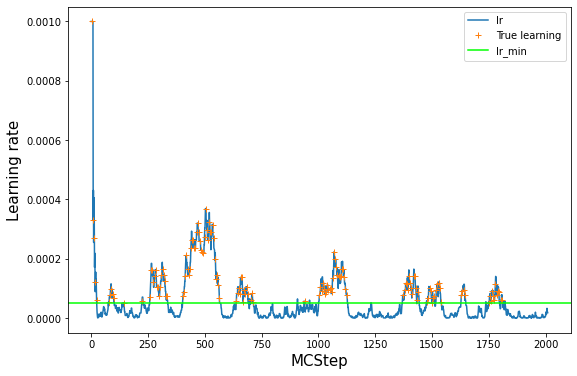

In [23]:
log_train = np.array(model.log_train_decision)
lr = log_train[:,1]
plt.plot(lr, label='lr')
# see where we really trained: everywhere where train=True
# set lr_true to NaN anywhere where we did not train to have a nice plot
lr_true = lr
lr_true[log_train[:,0] == False] = np.nan
plt.plot(lr_true, '+', label='True learning')
# lr_min as a guide to the eye
plt.axhline(model.ee_params['lr_min'], label='lr_min', color='lime')
plt.legend()
plt.xlabel('MCStep', size=15);
plt.ylabel('Learning rate', size=15);

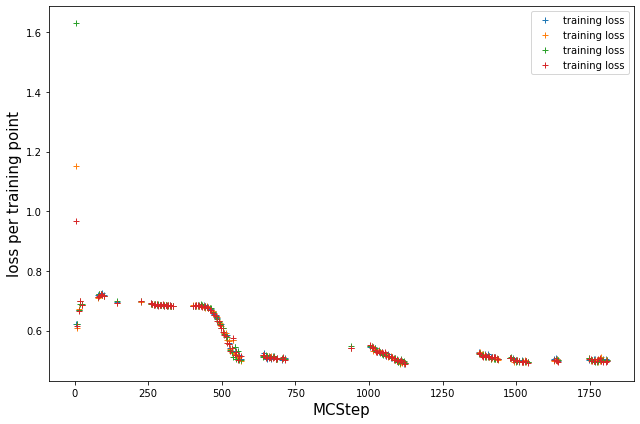

In [24]:
# resort such that we have a loss value per MCStep, NaN if we did not train at that step
train_loss = []
count = 0
for t in log_train[:, 0]:
    if t:
        train_loss.append(model.log_train_loss[count])
        count += 1
    else:
        train_loss.append([np.nan for _ in range(model.ee_params['epochs_per_train'])])
    
plt.plot(train_loss, '+', label='training loss')
plt.legend();
plt.ylabel('loss per training point', size=15)
plt.xlabel('MCStep', size=15)
plt.tight_layout()

In [25]:
# get the number of accepts from OPS storage
accepts = []
for step in storage.steps:
    if step.change.canonical.accepted:
        accepts.append(1.)
    else:
        accepts.append(0.)

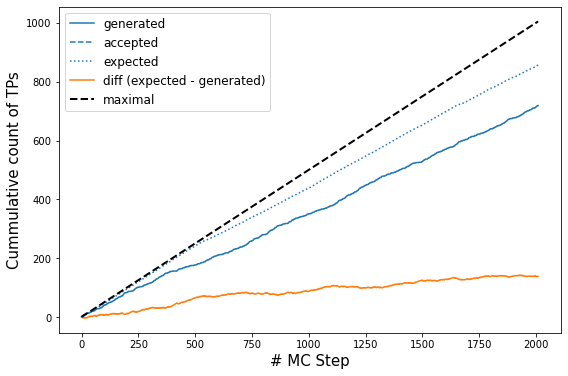

In [26]:
p_ex = np.array(model.expected_p)

l, = plt.plot(np.cumsum(trainset.transitions), label='generated');
plt.plot(np.cumsum(accepts), c=l.get_color(), ls='--', label='accepted');
plt.plot(np.cumsum(2*p_ex*(1 - p_ex)),c=l.get_color(), ls=':', label='expected');
plt.plot(np.cumsum(2*p_ex*(1 - p_ex))- np.cumsum(trainset.transitions), label='diff (expected - generated)')
plt.plot(np.linspace(0., len(trainset)/2., len(trainset)), c='k', ls='--', label='maximal', lw=2)
plt.legend(fontsize=12);
plt.ylabel('Cummulative count of TPs', size=15)
plt.xlabel('# MC Step', size=15);

In [27]:
storage.sync_all()
storage.close()

In [28]:
aimmd_storage.close()

In [29]:
# it is a good habit to also close the old storages,
# (although not stricly necessary since they have been opened in read-only mode)
old_storage.close()
old_aimmd_storage.close()